# CM Credits research question 1
In this notebook we will use supervised machine learning to try to answer the following question. To what extent is it possible to predict whether someone will experience payment delays based on all the characteristics of a person and their job, residence, etc.?

Here we import all libraries and functions we will be using

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# ignore future warnings
import warnings
warnings.filterwarnings("ignore")

## Application Data
This is the data we will be using

In [2]:
# read the application data from a csv file
app_data = pd.read_csv("src/application_data.csv",sep=",", encoding='cp1252', index_col=0)
app_data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Data understanding
We took a look at all the columnnames and their description and found a couple that could be interesting.

| Column name            | Column description                                                         | Level of measurement |
|------------------------|----------------------------------------------------------------------------|----------------------|
| TARGET                 | The target we want to guess                                                | Nominal              |
| CODE_GENDER            | What gender the client is                                                  | Nominal              |
| FLAG_OWN_REALTY        | Whether or not a client owns realty                                        | Nominal              |
| CNT_CHILDREN           | The amount of children the client has                                      | Interval             |
| AMT_INCOME_TOTAL       | The amount if income total the client has                                  | Interval             |
| AMT_CREDIT             | The amount of credit debt the client has                                   | Interval             |
| AMT_ANNUITY            | The amount of annuity debt the client has                                  | Interval             |
| NAME_EDUCATION_TYPE    | The highest type of education the client has finished                      | Ordinal              |
| NAME_FAMILY_STATUS     | The marital status of the client                                           | Nominal              |
| NAME_HOUSING_TYPE      | The living situation of the client                                         | Nominal              |
| DAYS_BIRTH             | How many days ago the client was born (negative number)                    | Interval             |
| FLAG_MOBIL             | Whether or not the client has a phone                                      | Nominal              |
| FLAG_WORK_PHONE        | Whether or not the client has a work phone                                 | Nominal              |
| FLAG_CONT_MOBILE       | Whether or not the client is picking up their phone                        | Nominal              |
| REG_CITY_NOT_LIVE_CITY | Whether or not the clients contact address mathces their permanent address | Nominal              |
| NAME_INCOME_TYPE       | The clients income type (business man, matternity leave, working..)        | Ordinal              |
| AMD_GOODS_PRICE        | The price of the goods for which the client has taken loans                | Interval             |
| DAYS_EMPLOYED          | The amount of days the player worked before application                    | Interval             |



To start, lets see what the correlation is between the quantitative features and the target

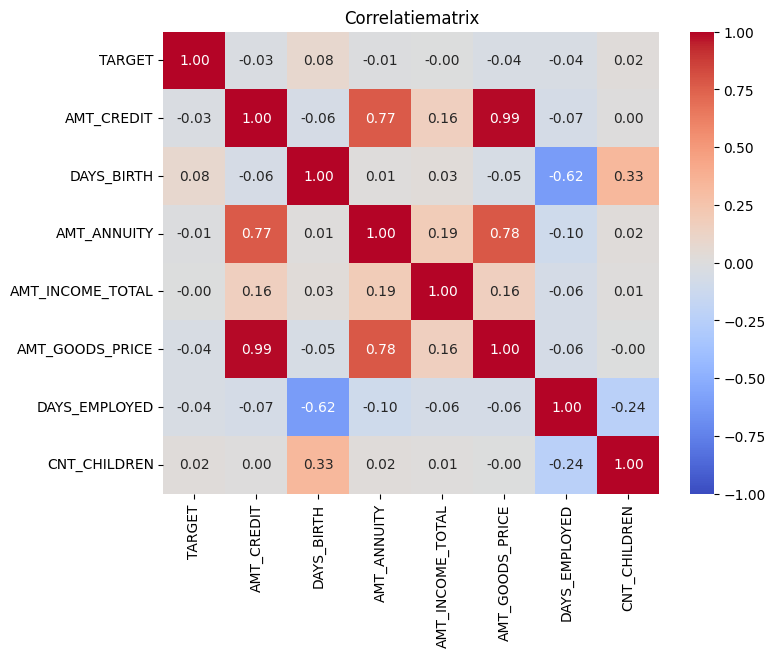

In [3]:
# create a correlation matrix of all quantitative features
corr_matrix = app_data[['TARGET', 'AMT_CREDIT', 
                        'DAYS_BIRTH', 'AMT_ANNUITY', 
                        'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 
                        'DAYS_EMPLOYED', 'CNT_CHILDREN']].corr()

# display the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlatiematrix')
plt.show()

There is some extremely low correlation between target and some of the features, lets see what the boxplots look like, and how many outliers there are.

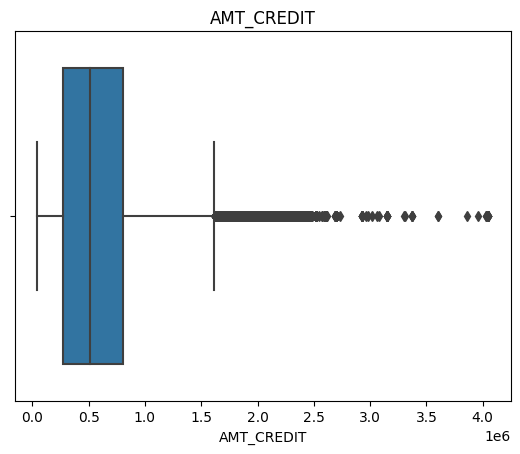

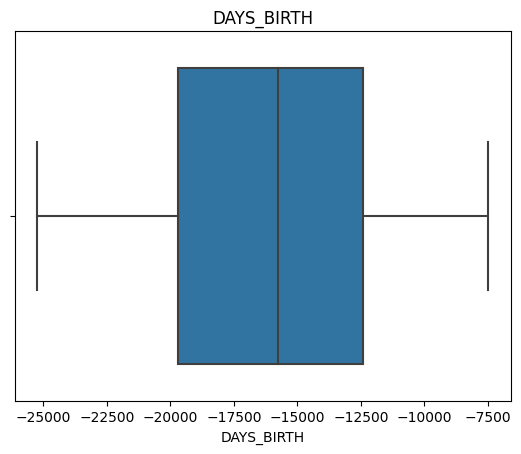

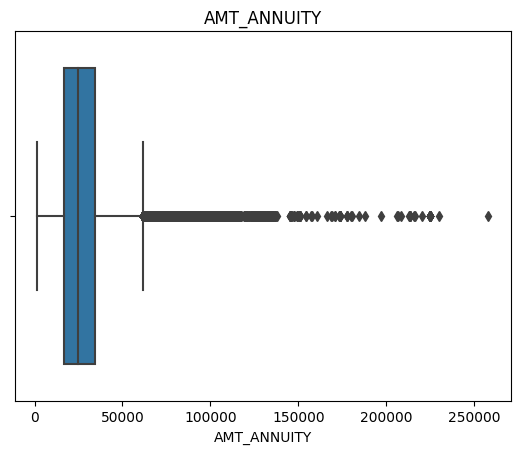

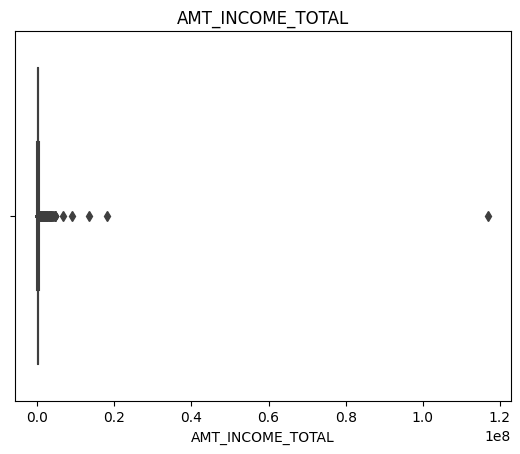

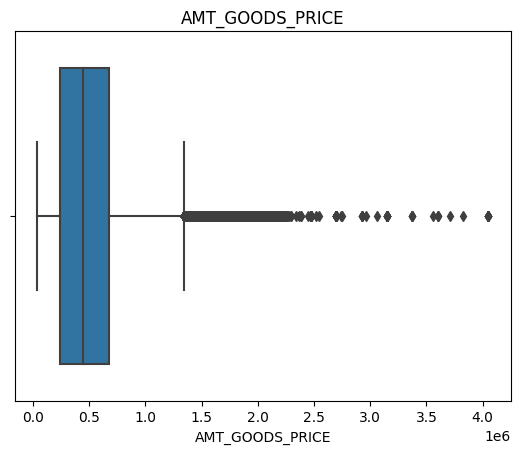

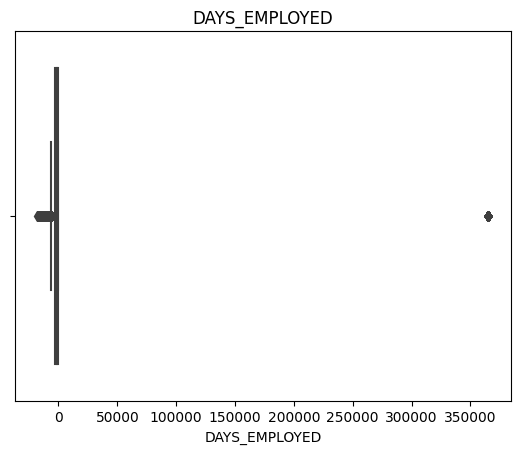

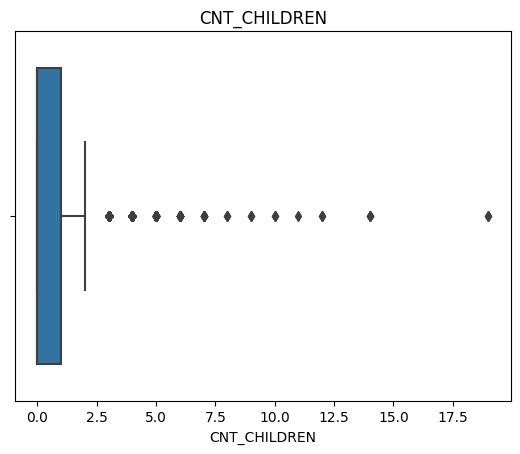

In [4]:
cols = ['AMT_CREDIT', 'DAYS_BIRTH', 
        'AMT_ANNUITY', 'AMT_INCOME_TOTAL',
        'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 
        'CNT_CHILDREN']

# show boxplots
for col in cols:
    sns.boxplot(x=app_data[col])
    plt.title(col)
    plt.show()

Some features have a lot of extreme outliers, we will definetely do something with that in data preparation. For now we decided to plot barcharts showing the interesting features and how many percent of people that fall in a given place of the feature have money problems. For example gender, how many percent of the clients that are male also have financial problems? The more the bars differ from eachother the more usefull the feature is.

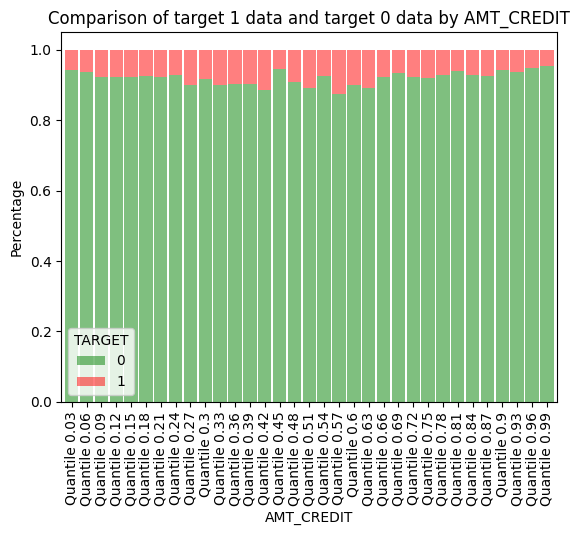

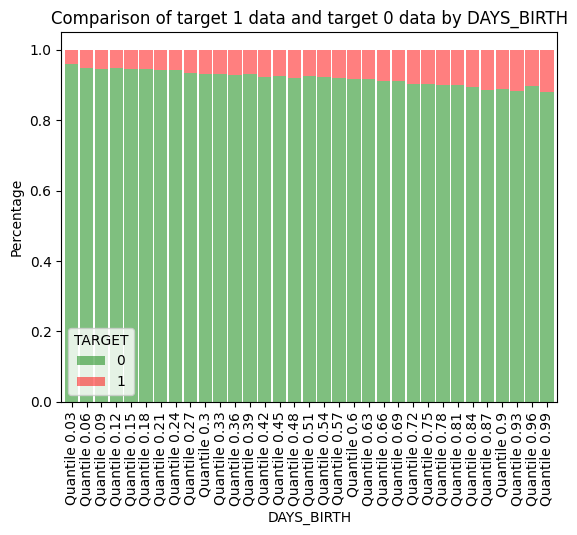

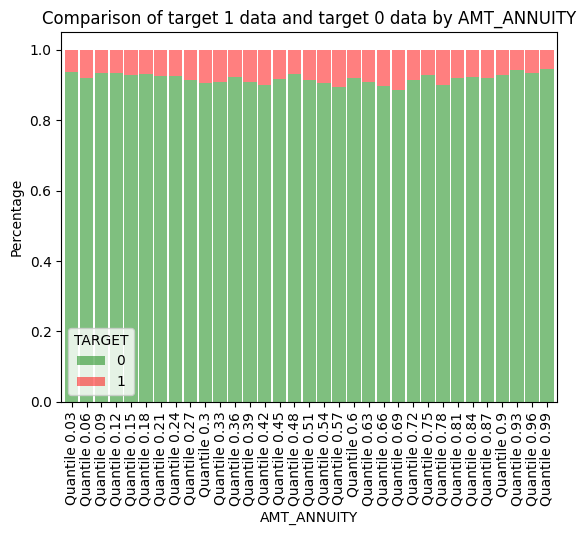

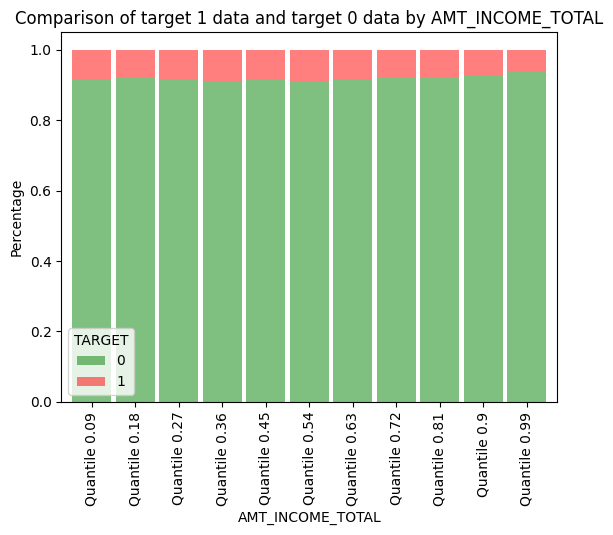

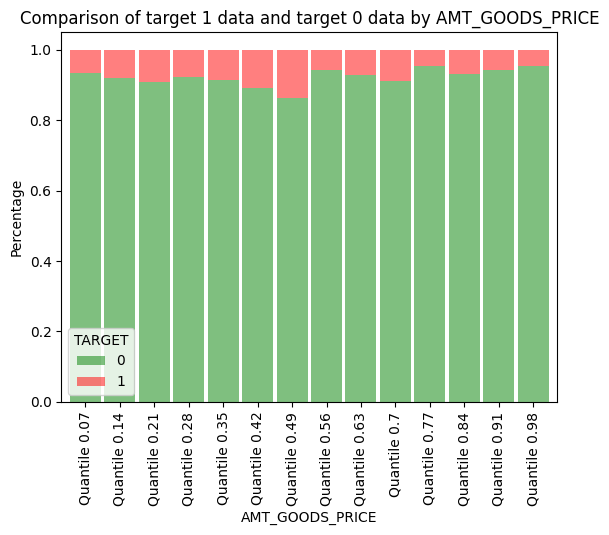

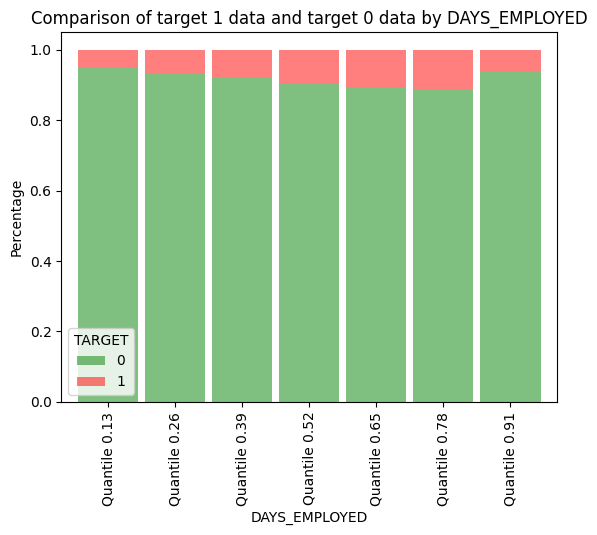

In [5]:
# loop through the quantitative columns of interest
columns = ['TARGET', 'AMT_CREDIT', 'DAYS_BIRTH', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED']
categorized_col = app_data[columns]
for col in columns[1:]:
    # get a list of as much ranges as possible with equal intervals based on the quantiles
    bin_intervals = [i for i in range(3,16)]
    for interval in bin_intervals:
        bins = [categorized_col[col].quantile(x/100) for x in range(0,101,interval)]
        if len(bins) == len(set(bins)):
            break

    # create a list of corresponding labels
    labels = [f"Quantile {x/100}" for x in range(0,101,interval)][1:]

    # create a new columns that shows in what range the datapoint belongs
    categorized_col[f'{col}_RANGE'] = pd.cut(categorized_col[col], bins=bins, labels=labels)

    # group and plot the data to get a stacked barchart with equal intervals of ranges
    # each range shows how much percent of datapoints in it has a target of 1
    col_counts = categorized_col.groupby(f'{col}_RANGE', observed=False)['TARGET'].value_counts(normalize=True).unstack()
    col_counts.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.5, width=0.9)

    #Add labels and a title
    plt.title(f"Comparison of target 1 data and target 0 data by {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.show()

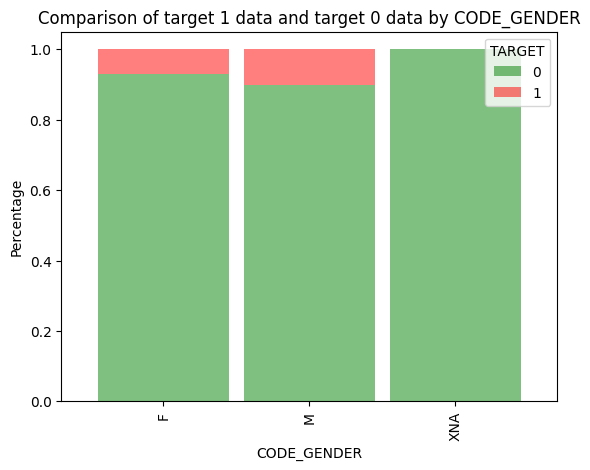

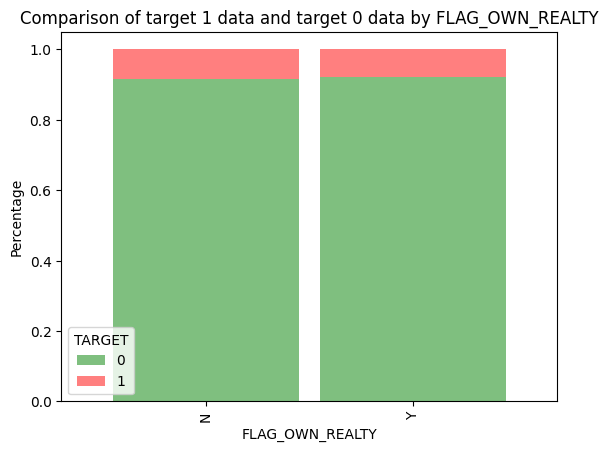

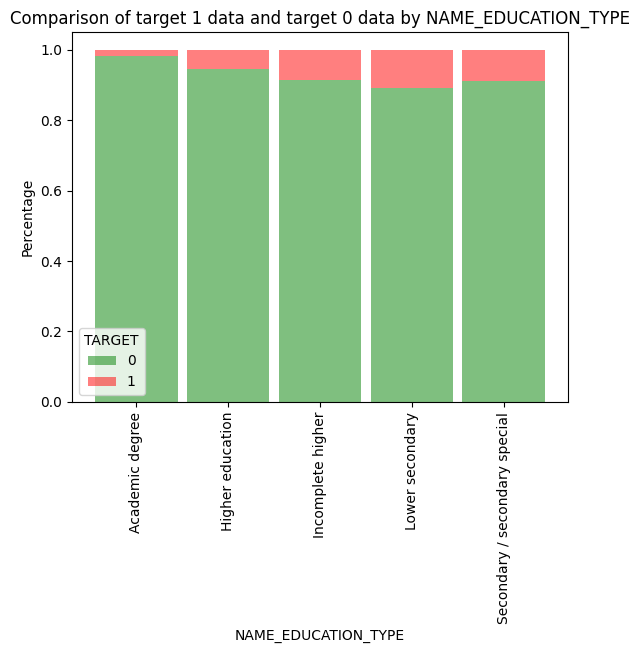

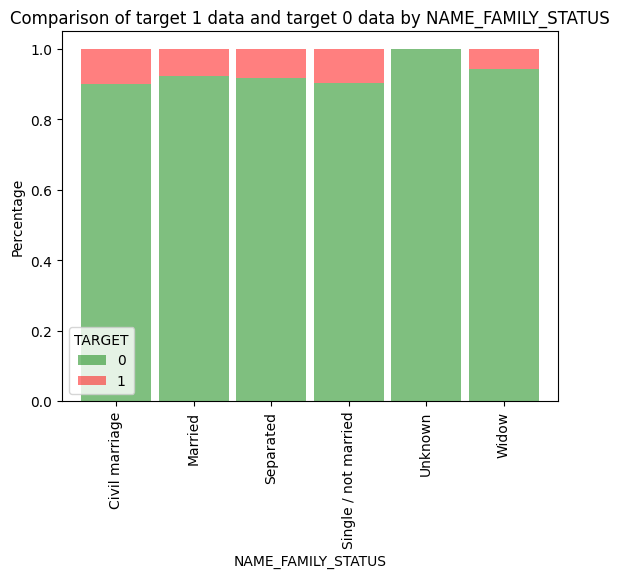

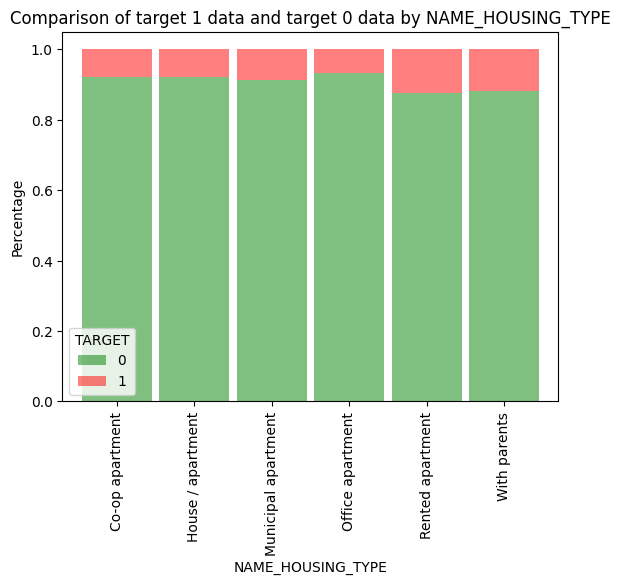

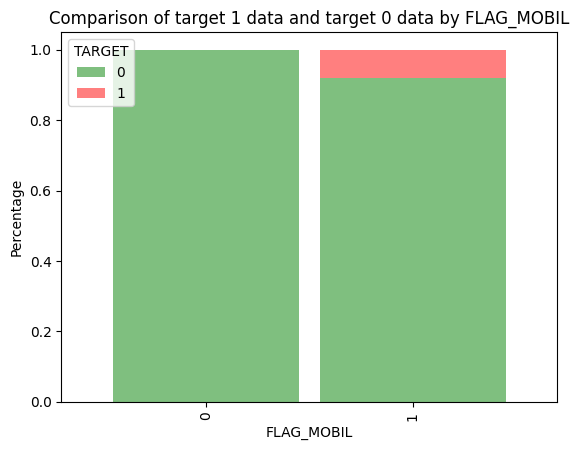

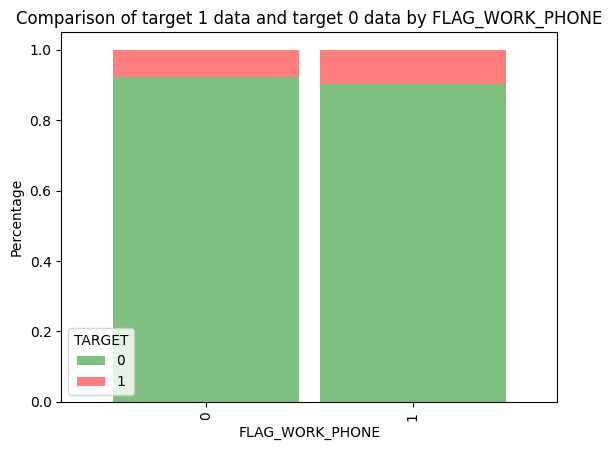

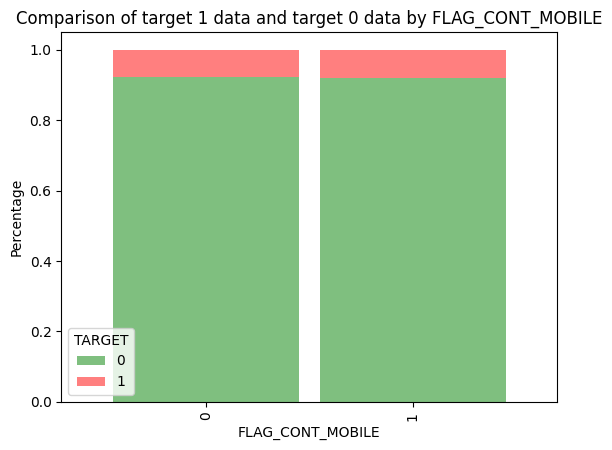

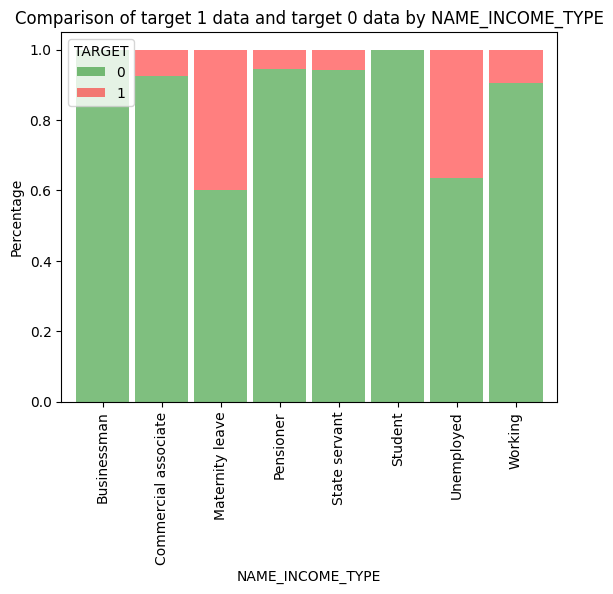

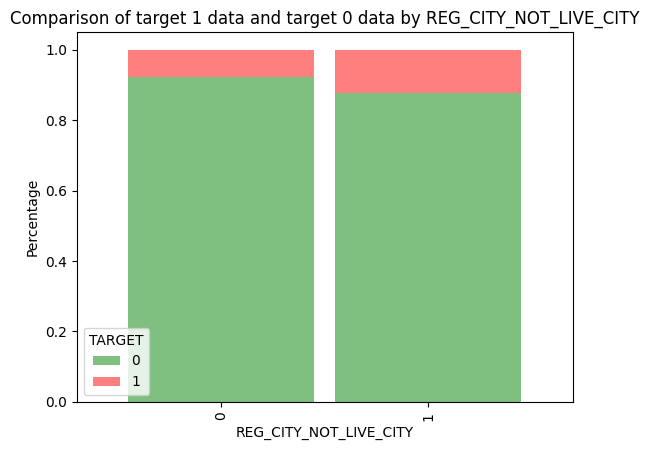

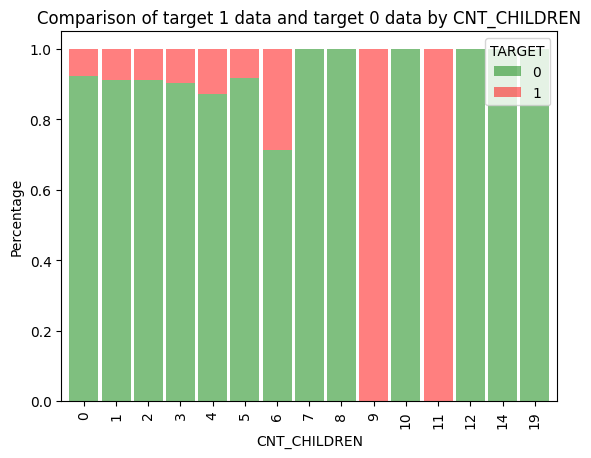

In [6]:
# loop through all qualitative features of interest
columns = ['CODE_GENDER', 'FLAG_OWN_REALTY', 
           'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
           'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 
           'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
           'NAME_INCOME_TYPE', 'REG_CITY_NOT_LIVE_CITY',
           'CNT_CHILDREN']

for col in columns:
    # group the datapoints and plot them stacked 
    gender_counts = app_data.groupby(col)['TARGET'].value_counts(normalize=True).unstack()
    gender_counts.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.5, width=0.9)
    
    # Add labels 
    plt.title(f"Comparison of target 1 data and target 0 data by {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.show()

## Data preparation

With the data visualisations given above for the first model chose to use 3 features, this is to keep it quick and simple which helps with evaluating our models. The chosen 3 were NAME_EDUCATION_TYPE, AMT_ANNUITY and DAYS_BIRTH, after looping through CRISP-DM several times we found out that the features CODE_GENDER, NAME_INCOME_TYPE, NAME_FAMILY_STATUS, AMT_GOODS_PRICE and DAYS_EMPLOYED were also needed to create the best model we could.

### Replace NaN values
Lets first remove all NaN values, but instead of removing the entire row, we will change the NaN vallues to the median of the column if the column is quantitative, if the column is qualitative we will replace them with the mode of that column.

In [7]:
# replace all nans with the median if the value is quantitative, and replace with mode if the value is qualitative
for col in ['CODE_GENDER',         'NAME_INCOME_TYPE', 
            'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
            'DAYS_BIRTH',          'AMT_ANNUITY',
            'AMT_GOODS_PRICE',     'DAYS_EMPLOYED']:
    if app_data[col].dtype != object:
        app_data[col].fillna(app_data[col].median(), inplace=True)
    else:
        app_data[col].fillna(app_data[col].mode()[0])

### Replace outliers
In data understanding we saw that the columns AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, CNT_CHILDREN and DAYS_EMPLOYED had some outliers that were way too big, lets change those datapoints to be the median.

In [8]:
for col in ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED',
           'AMT_CREDIT', 'AMT_ANNUITY',
           'AMT_GOODS_PRICE', 'CNT_CHILDREN']:
    # calculate q1 a3 and iqr
    q1 = app_data[col].quantile(0.25)
    q3 = app_data[col].quantile(0.75)
    iqr = q3 - q1
    
    # state borders for outliers
    upper = q3 + iqr
    lower = q1 - iqr
    
    # replace outliers
    app_data.loc[(app_data[col] > upper) | (app_data[col] < lower), col] = app_data[col].median()

### Fit features to model
Some of our features are qualitative, lets encode them to be interpreted as quantitative so we can use them in our KnearestNeighbors model

In [9]:
# use sklearn's preprocessing labelencoder to transform the qualitative labels to corresponding ints
encoder = LabelEncoder()
cols = ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS']
for col in cols:
    app_data[col] = encoder.fit_transform(app_data[col])

### Normalize data
Because we are using a model that is based on calculating distances we will be normalizing all non-encoded features we use

In [10]:
# normalize the quantitative features using the zscore
columns = ['DAYS_BIRTH','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED']
for col in columns:
    app_data[f'{col}_NORM'] = (app_data[col]-app_data[col].mean())/app_data[col].std()

## Baseline model
Lets set up a baseline to be able to verify in the future if our models will actually help.

In [11]:
# calculate how many percent of the datapoints has a target of 0
target_count = app_data['TARGET'].value_counts()
baseprob = target_count[0]/(target_count[0] + target_count[1])*100
round(baseprob, 2)

91.93

Here we can see that 91.93% of people do not have banking problems, we can use this to determine if we created a good model. If our model has a worse accuracy than 91.93% then we know it is a bad model.

## Modeling

### Setup
Before we can create our first model we declare the features we use and the target we need, we will also split our data into a train and a test set to be able to more accurately test if our model works. As well as that we will declare a parameter grid to give to a gridsearch function to be able to find the best combination of hyperparameters.

In [12]:
# assign used values to X and y
X = app_data[['NAME_EDUCATION_TYPE','DAYS_BIRTH_NORM','AMT_ANNUITY_NORM']]
y = app_data['TARGET']

# splits in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# setup possible params
param_grid = {
    'n_neighbors': [n for n in range(2, 31, 3)],
    'weights': ['uniform', 'distance']
}

### Grid search
gridsearch is a functionality of sklearn that will find the best hyperparameters of our model.

In [13]:
def knn_grid_search(X, y, param_grid, cv=5):
    # initiate the model
    knn = KNeighborsClassifier()
    
    # create a grid search
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)

    # get the result from the grid search
    best_params = grid_search.best_params_
    return (best_params['n_neighbors'], best_params['weights'], knn)

best_k, best_weight, knn = knn_grid_search(X, y, param_grid)
print(f"The best parameters found from the grid search were K = {best_k} and weights = {best_weight}")

The best parameters found from the grid search were K = 26 and weights = uniform


### Create model v1

In [14]:
# Set hyper parameters
knn.set_params(n_neighbors = best_k, weights = best_weight)

# Fit het model
knn.fit(X_train,y_train)

# Ons eerste predictie
y_pred = knn.predict(X_test)
print(f"Test: {round(accuracy_score(y_test, y_pred)*100, 2)}%")

# Trainset score
y_train_pred = knn.predict(X_train)
print(f"Train: {round(accuracy_score(y_train, y_train_pred)*100, 2)}%")

Test: 92.08%
Train: 91.88%


Using the features 'NAME_EDUCATION_TYPE','AMT_ANNUITY_NORM' and 'DAYS_BIRTH_NORM', the best outcome we got was 92.08% accuracy on the testset and 91.88% accuracy on the trainset with K = 26 and weights = uniform. A test-accuracy higher than the train-accuracy is slightly suspicious, let's see what the confusionmatrix looks like.

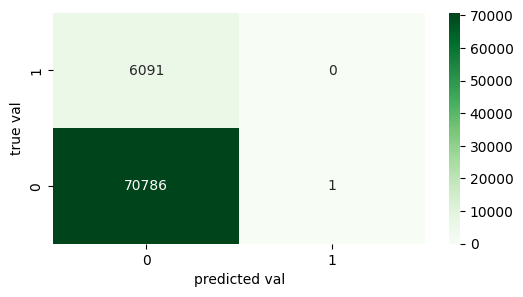

In [15]:
def draw_conf_matrix(test, pred):
    # Create the confusion matrix
    conf_matrix = confusion_matrix(test, pred)[::-1]

    # Set the figure size
    plt.figure(figsize=(6, 3))

    # Create a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Greens', yticklabels=['1', '0'])

    # Add labels and show
    plt.xlabel('predicted val')
    plt.ylabel('true val')
    plt.show()
    
draw_conf_matrix(y_test, y_pred)

Here we can see that our model almost never predicts a datapoint to be a target, it only looks like our model is better than the baseline because our test set luckilly has less targets in it (which explains why the model has a higher accuracy on the test set compared to the train set). It is likely that our model ignores the targets because there are just so few in our dataset. To solve this we will be doing some oversampling, that means that we will be creating some artificial target-datapoints that are representable so the model has more to learn from. The downside to oversampling is that it is unsure whether the data you created is 100% representable.
![oversampling.png](src/images/oversampling.png)

### Create model v2
Before we can start we will be oversampling our train dataset, never oversample the testset because you could change the representability.

In [16]:
def oversample(X, y):
    # count the values before oversampling
    ratio_pre = y.value_counts()
    print(f"The ratio before oversampling is {ratio_pre[0]} non-targets to {ratio_pre[1]} targets, which is {round(ratio_pre[0]/ratio_pre[1])}-1")

    # oversample
    smote = SMOTE(random_state=0)
    X_smote, y_smote = smote.fit_resample(X, y)

    # count the values after oversampling
    ratio_post = y_smote.value_counts()
    print(f"The ratio after oversampling is {ratio_post[0]} non-targets to {ratio_post[1]} targets, which is {round(ratio_post[0]/ratio_post[1])}-1")
    
    # return the oversampled data
    return (X_smote, y_smote)

X_train_smote, y_train_smote = oversample(X_train, y_train)

The ratio before oversampling is 211899 non-targets to 18734 targets, which is 11-1
The ratio after oversampling is 211899 non-targets to 211899 targets, which is 1-1


### Grid search

In [17]:
best_k, best_weight, knn = knn_grid_search(X_train_smote, y_train_smote, param_grid)
print(f"The best parameters found from the grid search were K = {best_k} and weights = {best_weight}")

The best parameters found from the grid search were K = 5 and weights = distance


### Train model

In [18]:
# Set hyper parameters
knn.set_params(n_neighbors = best_k, weights = best_weight)

# Fit the model
knn.fit(X_train_smote,y_train_smote)

# Create a prediction on the test set
y_pred = knn.predict(X_test)
print(f"Test: {round(accuracy_score(y_test, y_pred)*100, 2)}%")

# Trainset score
y_train_pred = knn.predict(X_train)
print(f"Train: {round(accuracy_score(y_train, y_train_pred)*100, 2)}%")

Test: 68.94%
Train: 99.79%


The test score went down, usually that is bad but in this case it shows that our oversampling worked, to be sure this is the case let's see what de confusionmatrix tells us.

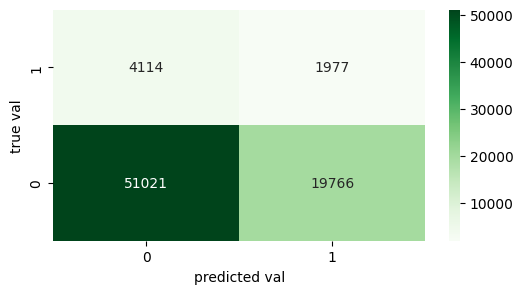

In [19]:
draw_conf_matrix(y_test, y_pred)

Thats not too good, lets see if we can improve this by enacting a threshold on which the model can make predictions, this in the hope that the model will predict more targets correctly rather than incorrectly. we'll see if this does any good by calculating the precision, recall and f1 score. The precision tells us how much percent of the positive predictions is true. The recall tells us how much percent of the positive scores is predicted as positive. The f1 score is the harmonic mean of these two.

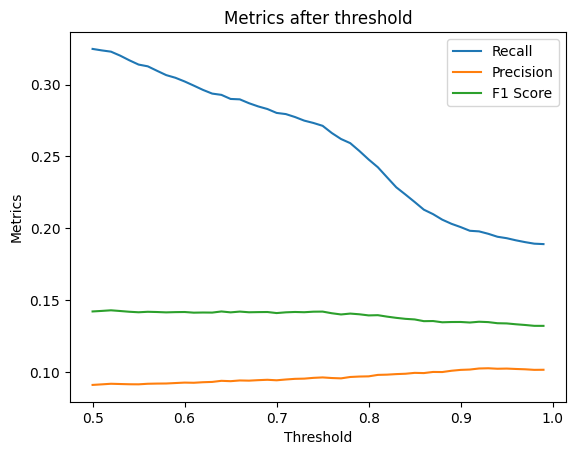

The best f1 score is 0.14 and it occurs when enacting a threshold of 0.52


In [20]:
# get predictions and probabilities
y_pred = knn.predict(X_test)
pred_proba = knn.predict_proba(X_test)

# write function to enact threshold on a series of predictions, probabilities and testset 
def with_threshold(t, pred, pred_proba, test):
    # create a mask
    mask_1 = (pred == 1) & (pred_proba[:, 1] > t)
    mask_0 = (pred == 0) & (pred_proba[:, 0] > t)
    combined_mask = mask_1 | mask_0

    # Remove the corresponding elements from y_pred
    pred_filtered = pred[combined_mask]
    test_filtered = test[combined_mask]
    
    return (pred_filtered, test_filtered)

def find_best_threshold(pred, proba, test):
    # Create lists to plot later
    thresholds = []
    recalls = []
    precisions = []
    f1s = []

    # Save the max score
    max_score = -1
    max_score_t = 0.5

    # get different thresholds to find the best
    for t in np.arange(0.5, 1.0, 0.01):
        y_pred_filtered, y_test_filtered = with_threshold(t, pred, proba, test)

        # Get the true and false positives and negatives
        true_positives = len(y_pred_filtered[(y_test_filtered == 1) & (y_pred_filtered == 1)])
        false_positives = len(y_pred_filtered[(y_test_filtered == 0) & (y_pred_filtered == 1)])
        false_negatives = len(y_pred_filtered[(y_test_filtered == 1) & (y_pred_filtered == 0)])

        # Get the recall, precision and f1 score
        recall = true_positives/(true_positives+false_negatives)
        precision = true_positives/(true_positives+false_positives)
        f1 = 2 * (precision * recall) / (precision + recall)

        # Add all values to lists to be able to plot them
        f1s.append(f1)
        recalls.append(recall)
        precisions.append(precision)
        thresholds.append(t)

        # remember the highest f1 score
        if f1 > max_score:
            max_score = f1
            max_score_t = t

    # Plot the three lines
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, f1s, label='F1 Score')

    # Add labels and a legend
    plt.xlabel('Threshold')
    plt.ylabel('Metrics')
    plt.title('Metrics after threshold')
    plt.legend()

    # Show the plot
    plt.show()

    # return the best score and threshold
    return(max_score, max_score_t)

# find the best threshold
max_score, max_score_t = find_best_threshold(y_pred, pred_proba, y_test)
print(f"The best f1 score is {round(max_score, 2)} and it occurs when enacting a threshold of {max_score_t}")

This f1 score pales in comparison to what is expected of a good supervised machine learning model, let's see if the test score improved after enacting the threshold.

In [21]:
# enact the best threshold
y_pred_filtered, y_test_filtered = with_threshold(max_score_t, y_pred, pred_proba, y_test)

# Create a prediction on the test set
print(f"Test: {round(accuracy_score(y_test_filtered, y_pred_filtered)*100, 2)}%")

Test: 69.33%


The testscore only improved by 0.39%pt, that is not as much as we had liked, let's take a look a the confusionmatrix to see what kind of effect the thresholding had.

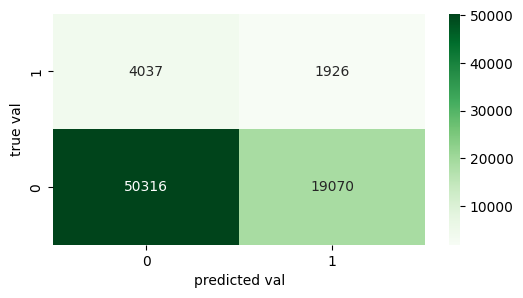

In [22]:
draw_conf_matrix(y_test_filtered, y_pred_filtered)

This model was mediocre to say the least. we have repeated the previous process a couple of times adding and removing different features and the following is the best we got.

### Create model v3
#### Setup

In [23]:
# assign used values to X and y
X = app_data[['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
              'NAME_FAMILY_STATUS', 'DAYS_BIRTH_NORM','AMT_ANNUITY_NORM',
              'AMT_GOODS_PRICE_NORM','DAYS_EMPLOYED_NORM']]
y = app_data['TARGET']

# splits in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Oversample

In [24]:
X_train_smote, y_train_smote = oversample(X_train, y_train)

The ratio before oversampling is 211899 non-targets to 18734 targets, which is 11-1
The ratio after oversampling is 211899 non-targets to 211899 targets, which is 1-1


### Grid search

In [25]:
best_k, best_weight, knn = knn_grid_search(X_train_smote, y_train_smote, param_grid)
print(f"The best parameters found from the grid search were K = {best_k} and weights = {best_weight}")

The best parameters found from the grid search were K = 2 and weights = distance


### Train model

In [26]:
# Set hyper parameters
knn.set_params(n_neighbors = best_k, weights = best_weight)

# Fit the model
knn.fit(X_train_smote,y_train_smote)

# Create a prediction on the test set
y_pred = knn.predict(X_test)
print(f"Test: {round(accuracy_score(y_test, y_pred)*100, 2)}%")

# Trainset score
y_train_pred = knn.predict(X_train)
print(f"Train: {round(accuracy_score(y_train, y_train_pred)*100, 2)}%")

Test: 77.29%
Train: 100.0%


77.29% is already better than the previous 69.33% we got, lets see what our confusion matrix looks like.

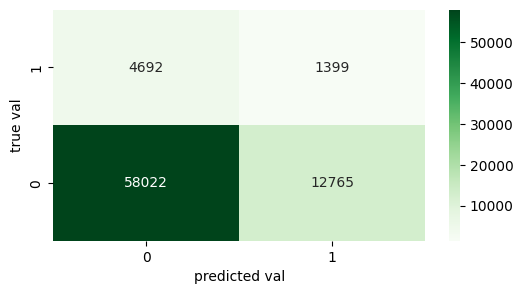

In [27]:
draw_conf_matrix(y_test, y_pred)

The confusion matrix is similar to our previous model, lets see if we can improve this through thresholding.

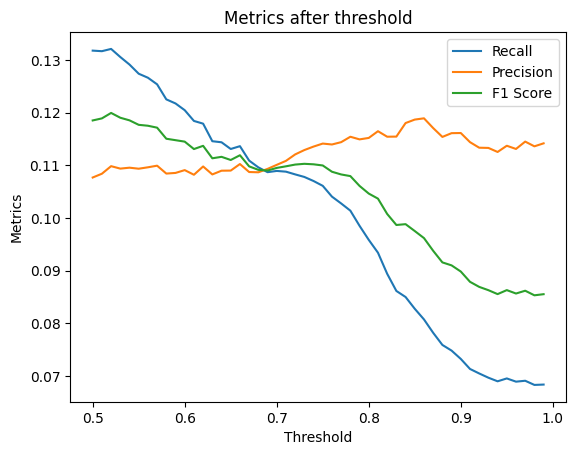

The best f1 score is 0.12 and it occurs when enacting a threshold of 0.52


In [28]:
max_score, max_score_t = find_best_threshold(y_pred, pred_proba, y_test)
print(f"The best f1 score is {round(max_score, 2)} and it occurs when enacting a threshold of {max_score_t}")

Our f1 score got a little lower, which is not too good, lets see if it improved the score any.

In [29]:
# enact the best threshold
y_pred_filtered, y_test_filtered = with_threshold(max_score_t, y_pred, pred_proba, y_test)

# Create a prediction on the test set
print(f"Test: {round(accuracy_score(y_test_filtered, y_pred_filtered)*100, 2)}%")

Test: 85.74%


If only judging based on accuracy score, the model improved by another 8.45%pt through thresholding. However this does not say much in this case because we dont necessarily want to be accurate overall but we mostly care about the accuracy of predicting the targets (also known as the f1 score). Lets see if the confusion matrix improved.

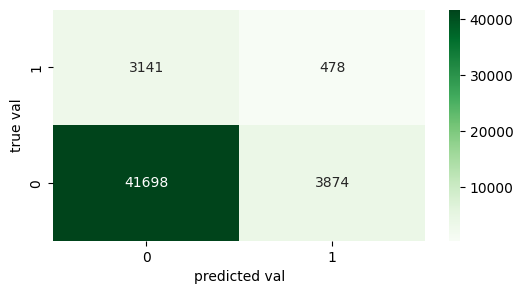

In [30]:
draw_conf_matrix(y_test_filtered, y_pred_filtered)

## Conclusion
We have used label encoding, normalization, train test split, gridsearch on all relevant hyperparameters, oversampling and thresholding to try to get the best model with the given data. Even when using multiple techniques to improve our model we can't get near the baseline nor the precision and recall we want to see. 

To answer the question 'To what extent is it possible to predict whether someone will experience payment delays based on all the characteristics of a person and their job, residence, etc.?', it is not possible/reliable to do this using supervised machine learning.